In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import galsim
import numpy as np
import matplotlib.pylab as plt
import lsst.afw.image as afwImg
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.galaxies import WLDeblendGalaxyCatalog  # one of the galaxy catalog classes
from descwl_shear_sims.stars import StarCatalog  # star catalog class
from descwl_shear_sims.psfs import make_ps_psf,make_fixed_psf  # for making a power spectrum PSF
from descwl_shear_sims.sim import get_se_dim  # convert coadd dims to SE dims

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
ifield=0
itest=0

rng = np.random.RandomState(ifield)

coadd_dim = 400
buff   = 50
rotate = False
dither = False

os.makedirs('outputs/test%d' %itest,exist_ok=True)

# this is the single epoch image sized used by the sim, we need
# it for the power spectrum psf
se_dim = get_se_dim(coadd_dim=coadd_dim, rotate=rotate, dither=dither)


nrot= 4
g1_list=[0.02,-0.02]
band_list=['r', 'i', 'z']
rot_list=[np.pi/nrot*i for i in range(nrot)]
nshear=len(g1_list)


if itest==0:
    args={
            'cosmic_rays':False,
            'bad_columns':False,
            'star_bleeds':False,
    }
    star_catalog=None
elif itest==1:
    args={
            'cosmic_rays':False,
            'bad_columns':False,
            'star_bleeds':False,
    }
    star_catalog = StarCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=buff,
        density=(ifield%1000)/10+1,
        layout='random_circle',
    )
elif itest==2:
    args={
            'cosmic_rays':True,
            'bad_columns':True,
            'star_bleeds':True,
    }
    star_catalog = StarCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=buff,
        density=(ifield%1000)/10+1,
        layout='random_circle',
    )

    
# galaxy catalog; you can make your own
galaxy_catalog = WLDeblendGalaxyCatalog(
    rng=rng,
    coadd_dim=coadd_dim,
    buff=buff,
    layout='random_circle',
)
#psf = make_ps_psf(rng=rng, dim=se_dim)
psf = make_fixed_psf(psf_type='moffat')

for irot in range(nrot):
    for ishear in range(nshear):
        sim_data = make_sim(
            rng=rng,
            galaxy_catalog=galaxy_catalog,
            star_catalog=star_catalog,
            coadd_dim=coadd_dim,
            g1=g1_list[ishear],
            g2=0.00,
            psf=psf,
            dither=dither,
            rotate=rotate,
            bands=band_list,
            noise_factor=0.,
            theta0=rot_list[irot],
            **args
        )
        for bb in band_list:
            sim_data['band_data'][bb][0].writeFits('outputs/test%d/field%04d_shear%d_rot%d_%s.fits' \
                               %(itest,ifield,ishear,irot,bb))

In [12]:
sim_data

{'band_data': {'r': [<lsst.afw.image.exposure.ExposureF at 0x14dd4c3ef130>],
  'i': [<lsst.afw.image.exposure.ExposureF at 0x14dd148ecdb0>],
  'z': [<lsst.afw.image.exposure.ExposureF at 0x14dd148d26f0>]},
 'coadd_wcs': FITS standard SkyWcs:
 Sky Origin: (200.0000000000, +0.0000000000)
 Pixel Origin: (1698.5, 1698.5)
 Pixel Scale: 0.2 arcsec/pixel,
 'psf_dims': (51, 51),
 'coadd_dims': (400, 400),
 'coadd_bbox': Box2I(corner=Point2I(1000, 450), dimensions=Extent2I(400, 400)),
 'bright_info': array([], dtype=int64),
 'se_wcs': [galsim.GSFitsWCS(_data = ['TAN', array([204.5, 204.5]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.4911423480046486, coord.radians), coord.Angle(-0.0010171386331415655, coord.radians)), None, None, None]),
  galsim.GSFitsWCS(_data = ['TAN', array([204.5, 204.5]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.4911423480046486, coord.radian

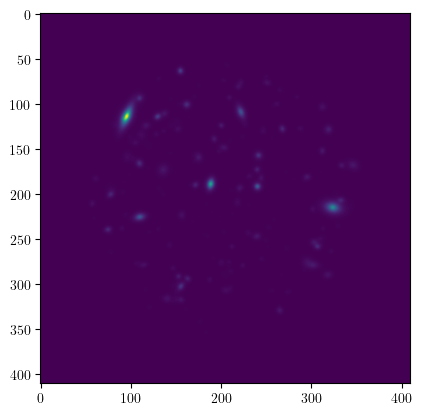

In [13]:
plt.close()
plt.imshow(sim_data['band_data']['i'][0].getImage().getArray())

In [14]:
print(sim_data['band_data']['i'][0].getPhotoCalib())

spatially constant with mean: 3.63078 error: 0


In [16]:
photoCalib=sim_data['band_data']['i'][0].getPhotoCalib()

In [20]:
np.log10(photoCalib.getInstFluxAtZeroMagnitude())*2.5

30.0

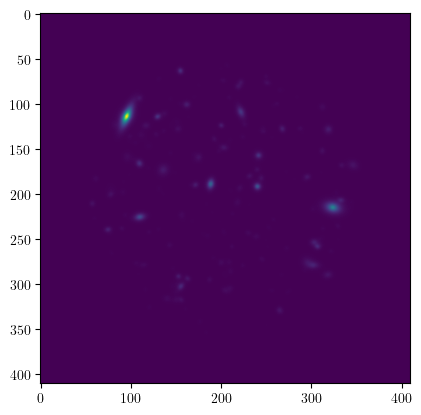

In [4]:
plt.close()
plt.imshow(sim_data['band_data']['r'][0].getImage().getArray())

In [5]:
info=sim_data['band_data']['i'][0].getInfo()
wcs=info.getWcs()
wcs.getPixelScale().asArcseconds()

0.19999999993572465

In [6]:
sim_data['psf_dims']

(51, 51)

In [12]:
sim_data['band_data']['i'][0].getPsf()

In [13]:
help(sim_data['band_data']['i'][0].writeFitsWithOptions)

Help on method exposureWriteFitsWithOptions in module lsst.afw.image.image._fitsIoWithOptions:

exposureWriteFitsWithOptions(dest, options) method of lsst.afw.image.exposure.ExposureF instance
    Write an Exposure or MaskedImage to FITS, with options
    
    Parameters
    ----------
    dest : `str`
        Fits file path to which to write the exposure or masked image.
    options : `lsst.daf.base.PropertySet`
        Write options. The items "image", "mask" and "variance" are read.
        Each must be an `lsst.daf.base.PropertySet` with data for
        ``lsst.afw.fits.ImageWriteOptions``.



In [20]:
print(sim_data['band_data']['i'][0].getPsf())

In [21]:
sim_data['band_data']['i'][0].writeFits('a.fits')

In [28]:
exp=afwImg.ExposureD.readFits('a.fits')
print(exp.getPsf())

None


In [23]:
afwImg.ExposureFitsReader.readPsf('a.fits')

TypeError: readPsf(): incompatible function arguments. The following argument types are supported:
    1. (self: lsst.afw.image.ExposureFitsReader) -> lsst.afw.detection.Psf

Invoked with: 'a.fits'

In [30]:
import lsst.afw.math as afwMath
import lsst.afw.image as afwImg
import lsst.afw.geom as afwGeom
import lsst.meas.algorithms as meaAlg


psfLsst     =   afwImg.ImageF(45,45)
psfLsst.getArray()[:,:]= np.zeros((45,45))
psfLsst     =   psfLsst.convertD()
kernel      =   afwMath.FixedKernel(psfLsst)
kernelPSF   =   meaAlg.KernelPsf(kernel)

In [53]:
help(kernelPSF.writeFits)

Help on method writeFits in module lsst.meas.algorithms.kernelPsf:

writeFits(...) method of lsst.meas.algorithms.kernelPsf.KernelPsf instance
    writeFits(*args, **kwargs)
    Overloaded function.
    
    1. writeFits(self: lsst.meas.algorithms.kernelPsf.KernelPsf, fileName: str, mode: str = 'w') -> None
    
    2. writeFits(self: lsst.meas.algorithms.kernelPsf.KernelPsf, manager: lsst.afw.fits._fits.MemFileManager, mode: str = 'w') -> None



In [ ]:
meaAlg.ImagePsf

In [47]:
exp.setPsf(kernelPSF)
exp.writeFits('b.fits')

In [48]:
exp2=afwImg.ExposureF.readFits('b.fits')

In [51]:
pp2=exp2.getPsf()

In [52]:
help(pp2.computeImage)

Help on method computeImage in module lsst.afw.detection:

computeImage(...) method of lsst.meas.algorithms.kernelPsf.KernelPsf instance
    computeImage(*args, **kwargs)
    Overloaded function.
    
    1. computeImage(self: lsst.afw.detection.Psf, position: lsst.geom.Point2D, color: lsst.afw.image.Color = <lsst.afw.image.Color object at 0x149c28bc4c70>, owner: lsst.afw.detection.Psf.ImageOwnerEnum = <ImageOwnerEnum.???: 0>) -> lsst::afw::image::Image<double>
    
    2. computeImage(self: lsst.afw.detection.Psf) -> lsst::afw::image::Image<double>



In [43]:
pp=psf.getPSF(galsim.PositionD(0,0))

In [44]:
pp

galsim.Transformation(galsim.Moffat(beta=2.5, scale_radius=0.7378921305736134, trunc=0.0, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.0149593012438465, 0.008423620428565835], [0.008423620428565835, 0.9853310927399]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

In [46]:
psf=sim_data['band_data']['i'][0].getPsf()

In [ ]:
psf.computeImage